<a href="https://colab.research.google.com/github/anushahulbatte/deeplearning/blob/main/Testing_with_GO_annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

if torch.__version__ != '2.5.1+cu124':
    !pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124 -U --quiet
    print("PyTorch version updated to 2.5.1.")
else:
    print("PyTorch is already at the correct version (2.5.1).")

PyTorch is already at the correct version (2.5.1).


In [2]:
!pip install d2l==1.0.3 --quiet
!pip install scipy --quiet
!pip install torchmetrics --quiet

In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler, random_split

from tqdm.auto import tqdm, trange
from matplotlib import pyplot as plt

DEVICE = torch.device("cpu")

In [4]:
import random
import os
import matplotlib.pyplot as plt
import csv
import numpy as np

In [5]:
import os
! git clone https://git.wur.nl/bioinformatics/grs34806-deep-learning-project-data.git
os.chdir("grs34806-deep-learning-project-data")

fatal: destination path 'grs34806-deep-learning-project-data' already exists and is not an empty directory.


In [68]:
def read(seqfile, posfile):
  """
  Extracting the sequences from the seqfile and creating a list called datalist.
  Making a list called labellist containing 0s and 1s, where 1 denotes the
  sequence identifiers in the posfile.
  """
  # Removing the sequence identifiers
  with open(seqfile, 'r') as f:
    seq_lines = [seq_lines.strip() for seq_lines in f.readlines() if seq_lines.strip()]
    #print(seq_lines)
  seq_ids = []
  datalist = []
  current_seq = ""
  for line in seq_lines:
    if line.startswith("ENSG"):
      parts = line.split()
      #print(parts)
      seq_ids.append(parts[0])
      datalist.append(parts[1])

  with open(posfile, 'r') as f:
    annotated_ids = [line.strip() for line in f.readlines() if line.strip()]
    #print(annotated_ids)
  labellist = [1 if seq_id in annotated_ids else 0 for seq_id in seq_ids]

  print("Length of the datalist: ", len(datalist))
  print("Length of labellist: ", len(labellist))
  print("The number of positives in labellist: ", sum(labellist))
  #for i in range(min(5, len(datalist))):
        #print(f"ID: {seq_ids[i]}, Has annotation: {labellist[i]}, Sequence length: {len(datalist[i])}")

  print(labellist)
  return datalist, labellist


Testing with the sequence file as the positively annotated GO sequence identifiers for mitochondria.

In [97]:
datalist, labellist = read(seqfile = "/content/grs34806-deep-learning-project-data/expr5Tseq_filtGO_100-1000.lis",
posfile = "/content/grs34806-deep-learning-project-data/GO_3A0005739.annotprot")


Length of the datalist:  6784
Length of labellist:  6784
The number of positives in labellist:  472
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [70]:
import numpy as np
from sklearn.model_selection import train_test_split

def generate_train_val_test(datalist, labellist, test_size=0.2, val_size=0.25,
                            random_state=42):
  """
  First splitting the data into training and testing sets.
  And then separating the training set into a validation set.
  This is done in a 60%, 20% and 20% manner.
  """
  trainval_data, test_data, trainval_labels, test_labels = train_test_split(
      datalist, labellist, test_size=test_size,
      random_state = random_state
  )

  train_data, val_data, train_labels, val_labels = train_test_split(
      trainval_data, trainval_labels, test_size=val_size,
      random_state=random_state
  )

  return train_data, val_data, test_data, train_labels, val_labels, test_labels

In [32]:
train_data, val_data, test_data, train_labels, val_labels, test_labels = generate_train_val_test(
    datalist, labellist
)


In [33]:

print("Training data size:", len(train_data))
print("Training labels size:", len(train_labels))
print("Validation data size: ", len(val_data))
print("Validation labels size: ", len(val_labels))
print("Test data size:", len(test_data))
print("Test labels size:", len(test_labels))

Training data size: 4070
Training labels size: 4070
Validation data size:  1357
Validation labels size:  1357
Test data size: 1357
Test labels size: 1357


In [34]:
def tokenize(dat, map2num, non_aa_num=20):
  """
  This function takes in the sequences of AA. It uses dictionary mapping, to map
  AA to integers. The non_aa_num make up the unknown AA, and its default value is
  20.
  """
  seq = []
  for count, i in enumerate(dat):
      seq.append([map2num.get(j, non_aa_num) for j in list(i)])
  return seq

In [35]:
def build_seq_array(lines, num_steps, non_aa_num=20):
  """
  This function applies the truncate_pad function to all the sequences.
  It then converts the sequences into tensors.
  """
  array = torch.tensor([
      truncate_pad(l, num_steps, non_aa_num) for l in lines])
  return array


In [36]:
def truncate_pad(line, num_steps, padding_token):
  """
  The line in the parameters refers to the tokenized sequence.
  num_steps is the maxmimum sequence length. The padding_token is the integer
  for padding.
  The function pads shorter sequences with padding_token.
  """
  if len(line) > num_steps:
    return line[:num_steps] #Truncate
  return line + [padding_token] * (num_steps - len(line))


In [20]:
from d2l import torch as d2l

In [41]:
def load_data(batch_size, num_steps, dataset, trainlabels = None):
  mapaa2num = {aa: i for (i, aa)
                      in enumerate(list("ACDEFGHIKLMNPQRSTVWY"))}
  # Creating a dictionary which maps each AA to a unique integer
  seq, lab = dataset, trainlabels # lab is the labels which are associated with sequences

  seq = tokenize(seq, mapaa2num)
  seq_array = build_seq_array(seq, num_steps) # Shape = batch_size, num_steps

  # To convert the sequences to one-hot encoding
  # one_hot method takes a tensor and returns a tensor of shape of num_classes
  vocab_size = len(mapaa2num) +1
  seq_onehotencoding = F.one_hot(seq_array, num_classes=vocab_size).float()
  seq_onehotencoding = seq_onehotencoding.permute(0,2,1)
  # Shape = batch_size, vocab_size, num_steps

  data_arrays = (seq_onehotencoding, torch.tensor(lab))
  #data_arrays = (seq_array, torch.tensor(lab))
  data_iter = d2l.load_array(data_arrays, batch_size)
  #print("Shape of seq_array: ", seq_array.shape)
  #print("Shape of data_arrays, which now considers \none-hot encoded sequence: ",
        #seq_onehotencoding.shape)
  return data_iter

In [16]:
print("Unique labels:", torch.unique(torch.tensor(train_labels)))

Unique labels: tensor([0, 1])


In [42]:
train_iter = load_data(batch_size = 25, num_steps=20, dataset=train_data, trainlabels=train_labels)
validation_iter = load_data(batch_size=25, num_steps=20, dataset=val_data, trainlabels=val_labels)
test_iter = load_data(batch_size= 25, num_steps = 20, dataset = test_data, trainlabels = test_labels)

In [43]:
class ProteinCNN1D(nn.Module):
  def __init__(self, vocab_size:int, context_size:int, conv_channels:int=512,
                use_bias:bool=False, dropout_rate = 0.5, lr = 1, weight_decay=1e-4,
               momentum = 0):
      super().__init__()
      assert context_size % 2 == 0, f'Invalid block_size, {context_size} is not an even number'
      self.vocab_size = vocab_size
      self.context_size = context_size
      self.momentum = momentum
      self.cnn = nn.Sequential(
          nn.Conv1d(in_channels=self.vocab_size,
                    out_channels=conv_channels,
                    kernel_size=3,
                    padding='same',
                    bias=use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=conv_channels,
                    out_channels=256,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Conv1d(in_channels=256,
                    out_channels=128,
                    kernel_size = 3,
                    padding = 'same',
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.MaxPool1d(kernel_size = 2, stride = 2),

          nn.Flatten(),
          nn.Linear(in_features = int(128*(self.context_size//8)),
                    out_features = 256,
                    bias = use_bias),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(in_features = 256,
                    out_features = 1,
                    bias = use_bias)

      )
  def forward(self, X:torch.tensor, targets: torch.tensor=None) -> tuple[torch.tensor, torch.tensor]:
    logits = self.cnn(X).squeeze(1)
    loss = None if targets is None else F.binary_cross_entropy_with_logits(
        logits, targets.float())
    return logits, loss



In [45]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)
      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.5).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.5).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.5).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 0.2644, Validation Accuracy: 0.9197
Epoch 2: Train Loss: 0.2334, Validation Accuracy: 0.9197
Epoch 3: Train Loss: 0.2285, Validation Accuracy: 0.9197
Epoch 4: Train Loss: 0.2200, Validation Accuracy: 0.9197
Epoch 5: Train Loss: 0.2213, Validation Accuracy: 0.9197
Epoch 6: Train Loss: 0.1990, Validation Accuracy: 0.9189
Early stopping triggered at epoch 6

Final Test Accuracy: 0.9270


Epoch 1: Train Loss: 0.2742, Val Loss: 0.3170, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 2: Train Loss: 0.2430, Val Loss: 0.3340, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 3: Train Loss: 0.2290, Val Loss: 0.3763, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 4: Train Loss: 0.2188, Val Loss: 0.2615, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 5: Train Loss: 0.2138, Val Loss: 0.3722, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 6: Train Loss: 0.2125, Val Loss: 0.3752, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 7: Train Loss: 0.1966, Val Loss: 0.2710, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 8: Train Loss: 0.1893, Val Loss: 0.2927, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 9: Train Loss: 0.1821, Val Loss: 0.2692, Val Acc: 0.9197, Test Acc: 0.9270
Epoch 10: Train Loss: 0.1745, Val Loss: 0.2731, Val Acc: 0.9197, Test Acc: 0.9278


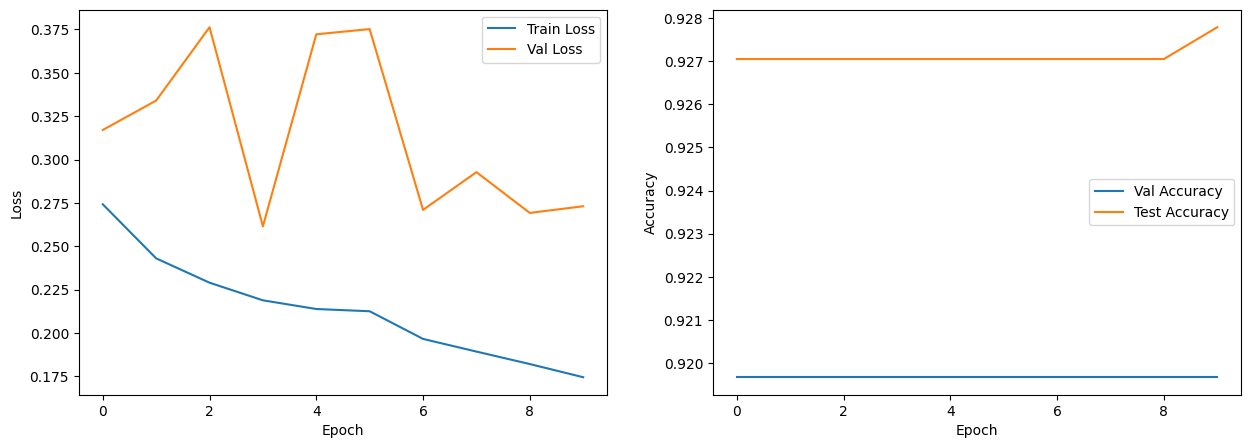

In [47]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 10
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [81]:
def evaluate_with_confusion_matrix(model, data_iter):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, _ = model(X)
            preds = (torch.sigmoid(logits) > 0.5).float()  # Threshold at 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Return metrics (optional)
    accuracy = (all_preds == all_labels).mean()
    print(f"Test Accuracy: {accuracy:.4f}")
    return cm

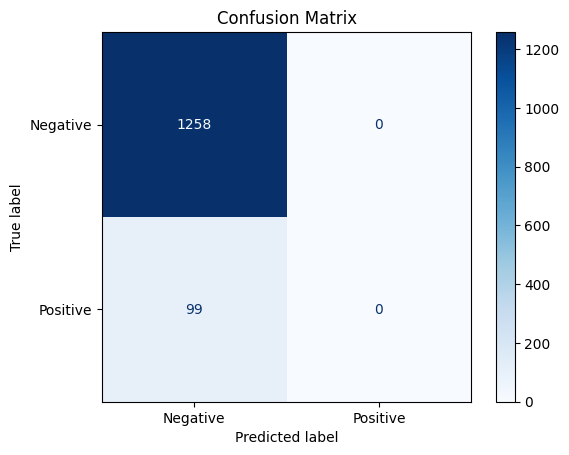

Test Accuracy: 0.9270


In [82]:
test_cm = evaluate_with_confusion_matrix(model, test_iter)

Due to a highly imbalanced dataset, only a very few positively annotated sequences, the model is good at predicting the 0s but it fails to predicts the 1s. To address this, we make use of class weighting.
Also decreasing the threshold from 0.5 to 0.3 to make classifying more lenient. Increased the number of epochs as well for better training time.

In [83]:
print(train_labels) # The labels are 1ss and 0s to represent positively annotated and not annotated respectively

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [86]:
neg_count = len(train_labels) - sum(train_labels)
pos_count = sum(train_labels)
print(neg_count)
print(pos_count) #The number of positively annotated labels

pos_weight = torch.tensor([neg_count / pos_count])  # Weight for positive class
print(f"Positive class weight: {pos_weight.item():.2f}")  # ~14 for your data (472 pos, 6312 neg)

3810
260
Positive class weight: 14.65


In [87]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(DEVICE))

In [93]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 25
weight_decay = 1e-4
best_loss =float('inf')


train_iter = load_data(batch_size=batch_size,
                       num_steps = context_size,
                       dataset=train_data,
                       trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                            num_steps=context_size,
                            dataset = val_data,
                            trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                      num_steps = context_size,
                      dataset = test_data,
                      trainlabels = test_labels)

# Initializing the model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias = False,
)
model.to(DEVICE)

# Using AdamW as the optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate,
                              weight_decay=weight_decay)

best_val_acc = 0.0
no_improve = 0
patience = 5 #This defines the number of epochs to wait before stopping
min_delta = 0.001 #The minimum amount of improvement to count as progress

train_losses = []
val_accuracies = []
test_accuracies=[]

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0
  for X, y in train_iter:
      X,y = X.to(DEVICE), y.to(DEVICE)

      #Forward pass
      logits, loss = model(X,y)

      #Computing weighted loss
      loss = criterion(logits.squeeze(), y.float())

      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      preds = (torch.sigmoid(logits)>0.4).float()
      correct += (preds == y).sum().item()
      total+= y.size(0)

  #Storing the training metrics
  train_accuracy = correct/total
  train_losses.append(epoch_loss/len(train_iter))

  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
      for X, y in validation_iter:
          X, y = X.to(DEVICE), y.to(DEVICE)
          logits, _ = model(X, y) #Looking at accuracy only
          val_loss += loss.item()
          preds = (torch.sigmoid(logits) > 0.4).float()
          val_correct += (preds == y).sum().item()
          val_total += y.size(0)

  current_val_acc= val_correct/val_total
  val_accuracies.append(current_val_acc)

  print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Validation Accuracy: {val_accuracies[-1]:.4f}')

  # Early stopping check
  if current_val_acc > best_val_acc+min_delta:
      best_val_acc = current_val_acc
      no_improve = 0
      torch.save(model.state_dict(), 'best_model.pth')  # Save best model
  else:
      no_improve += 1
      if no_improve >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}")
          model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Restore best model
          break

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for X, y in test_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, _ = model(X, y)
        preds = (torch.sigmoid(logits) > 0.4).float()
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

final_test_acc = test_correct / test_total
print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")

Epoch 1: Train Loss: 1.3074, Validation Accuracy: 0.0538
Epoch 2: Train Loss: 1.3016, Validation Accuracy: 0.0538
Epoch 3: Train Loss: 1.3171, Validation Accuracy: 0.0538
Epoch 4: Train Loss: 1.2975, Validation Accuracy: 0.0538
Epoch 5: Train Loss: 1.2982, Validation Accuracy: 0.0538
Epoch 6: Train Loss: 1.3043, Validation Accuracy: 0.0538
Early stopping triggered at epoch 6

Final Test Accuracy: 0.0641


Epoch 1: Train Loss: 1.3060, Val Loss: 0.6680, Val Acc: 0.0538, Test Acc: 0.0641
Epoch 2: Train Loss: 1.3105, Val Loss: 0.6883, Val Acc: 0.0538, Test Acc: 0.0641
Epoch 3: Train Loss: 1.2985, Val Loss: 0.6924, Val Acc: 0.0538, Test Acc: 0.0641
Epoch 4: Train Loss: 1.2948, Val Loss: 0.6328, Val Acc: 0.0538, Test Acc: 0.0641
Epoch 5: Train Loss: 1.2974, Val Loss: 0.6928, Val Acc: 0.0538, Test Acc: 0.0641
Epoch 6: Train Loss: 1.2972, Val Loss: 0.6690, Val Acc: 0.0538, Test Acc: 0.0641
Epoch 7: Train Loss: 1.2908, Val Loss: 0.6958, Val Acc: 0.0538, Test Acc: 0.0641
Epoch 8: Train Loss: 1.2901, Val Loss: 0.6869, Val Acc: 0.0538, Test Acc: 0.0641
Epoch 9: Train Loss: 1.3015, Val Loss: 0.7025, Val Acc: 0.0538, Test Acc: 0.0641
Epoch 10: Train Loss: 1.2838, Val Loss: 0.6283, Val Acc: 0.1238, Test Acc: 0.1312
Epoch 11: Train Loss: 1.2717, Val Loss: 0.6495, Val Acc: 0.1260, Test Acc: 0.1245
Epoch 12: Train Loss: 1.2378, Val Loss: 0.7040, Val Acc: 0.0906, Test Acc: 0.0958
Epoch 13: Train Loss: 1.1

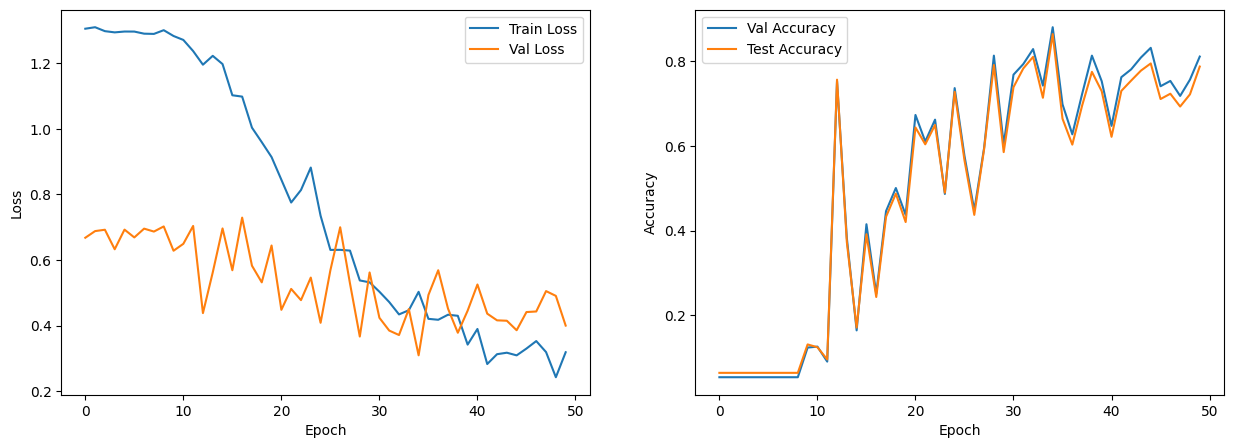

In [95]:
batch_size = 32
context_size = 100
train_frac = 0.8
learning_rate = 1e-3
dropout_rate = 0.5
num_epochs = 50
weight_decay = 1e-4

# Load all datasets
train_iter = load_data(batch_size=batch_size,
                      num_steps=context_size,
                      dataset=train_data,
                      trainlabels=train_labels)

validation_iter = load_data(batch_size=batch_size,
                          num_steps=context_size,
                          dataset=val_data,
                          trainlabels=val_labels)

test_iter = load_data(batch_size=batch_size,
                     num_steps=context_size,
                     dataset=test_data,
                     trainlabels=test_labels)

# Initialize model
model = ProteinCNN1D(
    vocab_size=21,
    context_size=context_size,
    conv_channels=512,
    use_bias=False
)
model.to(DEVICE)

# Optimizer
optimizer = torch.optim.AdamW(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0
    train_correct = 0
    train_total = 0

    for X, y in train_iter:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits, loss = model(X, y)
        loss = criterion(logits.squeeze(), y.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.4).float()
        train_correct += (preds == y).sum().item()
        train_total += y.size(0)

    train_losses.append(epoch_train_loss / len(train_iter))
    train_accuracy = train_correct / train_total

    # Validation evaluation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in validation_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            val_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.4).float()
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_losses.append(val_loss / len(validation_iter))
    val_accuracies.append(val_correct / val_total)

    # Test evaluation
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits, loss = model(X, y)
            test_loss += loss.item()
            preds = (torch.sigmoid(logits) > 0.4).float()
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_losses.append(test_loss / len(test_iter))
    test_accuracies.append(test_correct / test_total)

    # Print metrics
    print(f'Epoch {epoch+1}: '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Acc: {val_accuracies[-1]:.4f}, '
          f'Test Acc: {test_accuracies[-1]:.4f}')

# Plotting results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Better results ++ ADD MORE HERE

Trying with the signal transduction GO annotations.

In [96]:
datalist, labellist = read(seqfile = "/content/grs34806-deep-learning-project-data/expr5Tseq_filtGO_100-1000.lis",
posfile = "/content/grs34806-deep-learning-project-data/GO_3A0007165.annotprot")


Length of the datalist:  6784
Length of labellist:  6784
The number of positives in labellist:  420
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [98]:
train_data, val_data, test_data, train_labels, val_labels, test_labels = generate_train_val_test(
    datalist, labellist
)
